# Deep Learning


### Assignment 5

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
          'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string. This will create a variable called `words` which is the list of all words in the file (in order).

In [3]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


As we see, `words` is a list of 1 7005 207 elements!

#### Make the dataset

We will now create three variables:
 - `data`: is a list where each element is the frequency *ranking* of each word in `words`, e.g. since "the" is the most common, every time "the" appears in `words`, that element has value 1. For example, words[15] = "the" and data[15] = 1
 - `count`: is a list where each element is of the form ("word", frequency of that word). This list is ordered in descending order, i.e. the most frequent words appear first. We only tally the first vocabulary_size number of words.
 - `dictionary`: dict which translates each word into its position in the frequency ranking
 - `reverse_dictionary`: dict which translates each frequency ranking into the word with that ranking. E.g. reverse_dictionary[1] gives us the most common word of all, which is "the".

In [7]:
vocabulary_size = 50000

def build_dataset(words):
    # We set the unknown words at position 0
    count = [['UNK', -1]]
    # We will add elements to count that look like ("word", frequency) where
    # frequency in the number of occurrances. Most common ones appear first.
    # We stop adding tallying when we reach the vocabulary_size.
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    # Now count = [['UNK', -1], ("the", 1061396), ...]
    # We will make a dictionary where each word maps to the position in which
    # it can be found in the count list.
    dictionary = dict()
    for word, _ in count:
        # We grow the dictionary by adding words. Their position is then the
        # currrent length of the dictionary.
        dictionary[word] = len(dictionary)
    # We finished making the dictionary!
    # Now we make the data variable, which maps each element of words to its ranking in count
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    # We finished making data!
    # We also replace the unknown words with the correct number
    count[0][1] = unk_count
    # We now also make the reverse dictionary
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5237, 3084, 12, 6, 195, 2, 3136, 46, 59, 156]


#### Make a function for the input and output to the neural network model

In the skip-gram version of Word2Vec, the input data is the word and the label is its "context". Since there are multiple words in the context, we have to choose one each time. `skip_window` specifies how many words to consider left and right of our input word. `num_skips` specifies how many words from the window to use as labels for the input. E.g. if `skip_window` is set to 1 there are two words in the context, so setting `num_skips` to 2 means our network input is the [(word, left-word), (word, right-word)], i.e. we choose all words from the context, one at a time. `batch_size` just specifies how many input-output pairs to consider.

In [33]:
# This will keep track of how far in the data list we have reached in our training, 
# when taking minibatches. We start at the beginning.
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    # Look at the beginning index
    global data_index
    # We want the batch size to be a multiple of num_skips
    # so that each word gets to be paired with its full context
    assert batch_size % num_skips == 0
    # We don't want input be paired to a context-word more than once
    assert num_skips <= 2 * skip_window
    
    # We make empty lists into which we'll place the inputs and labels
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # span is the full length of a list containing the word plus its context
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    
    # We'll make a list with fast append and pop called buffer. This is
    # like a normal list but faster, and where we set the max length.
    # Once we append past max lenth, the first element is removed so that
    # we can tag on the last element
    buffer = collections.deque(maxlen=span)
    # We first fill the buffer with the context-words plus the input-word.
    # We start at the data_index and work our way forward, adding to data_index
    for _ in range(span):
        buffer.append(data[data_index])
        # If we run to the end of the data, start over
        data_index = (data_index + 1) % len(data)
    
    # The number of input words we can use is equal to batch_size / num_skips
    # E.g. batch_size = 8 and num_skips = 2 means each word appears twice, so we have 4 words.
    print("\nbuffer={}".format(buffer))
    for i in range(batch_size // num_skips): # // makes an int rather than a float
        # the variable target is the position in buffer of the label-word.
        # The input word needs a full context, so the position should always be equal to skip_window,
        # so we can explore to the left and right of it. We begin by setting target to skip_window, even though
        # this is precisely the position we want to avoid with our tagets. We'll change that later.
        target = skip_window
        targets_to_avoid = [ skip_window ]
        # For each time this word should appear, we tag it onto batch, where
        # label gets a different context-word each time
        for j in range(num_skips):
            # We take the targets in a random order that isn't in targets_to_avoid
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            # Now we have a valid target in the context. We add it to targets_to_avoid
            # so we don't choose it again
            targets_to_avoid.append(target)
            # Now we take the word in the middle of the buffer as the input-word,
            # and the target as the label.
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        # We now add the next word to the buffer to shift all its values forward by one,
        # and update the data_index.
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', data[:8])
print('(translated using reverse_dictionary):', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d (translated using reverse_dictionary):' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [[reverse_dictionary[li[0]]] for li in labels])

data: [5237, 3084, 12, 6, 195, 2, 3136, 46]
(translated using reverse_dictionary): ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

buffer=deque([5237, 3084, 12], maxlen=3)

with num_skips = 2 and skip_window = 1 (translated using reverse_dictionary):
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: [['as'], ['anarchism'], ['originated'], ['a'], ['term'], ['as'], ['of'], ['a']]

buffer=deque([5237, 3084, 12, 6, 195], maxlen=5)

with num_skips = 4 and skip_window = 2 (translated using reverse_dictionary):
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: [['a'], ['term'], ['originated'], ['anarchism'], ['term'], ['as'], ['originated'], ['of']]


Train a skip-gram model.

In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data. It's just a list of integers! We'll need to turn these
    # into vectors
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # Variables. embeddings turns our integers, representing words,
    # into vectors of length = vocabulary_size
    embeddings = tf.Variable(
      tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    
    softmax_weights = tf.Variable(
      tf.truncated_normal([vocabulary_size, embedding_size],
                           stddev=1.0 / math.sqrt(embedding_size)))
    
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
      tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                                 labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))
  
    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [8]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
          batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('\nAverage loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized

Average loss at step 0: 7.074467
Nearest to is: november, heydrich, buchanan, mccain, lubbock, mechanism, xi, aer,
Nearest to had: fraction, telegram, minster, reopening, regi, juniors, admirers, hbo,
Nearest to have: freed, ramp, answers, anu, postcards, pivotal, lobos, uranium,
Nearest to up: defensively, believe, vladimir, partake, kamakura, andamans, tice, simulate,
Nearest to system: amazons, summer, forests, shapeshifting, tailback, rid, concorde, oxidizer,
Nearest to to: trivial, exponent, microstates, wins, gions, abdicated, dlp, alto,
Nearest to however: prisma, lampoon, bulwark, loudest, themis, digitization, consumes, dhtml,
Nearest to most: m, afghana, neocortex, groot, kombinate, plenipotentiary, freleng, semifinals,
Nearest to his: picardy, debated, gelfand, lastly, buckminsterfullerene, protocol, aerosols, langevin,
Nearest to six: query, mahatma, tremor, chandra, finer, situ, biplanes, arjuna,
Nearest to that: cuailnge, millar, yogurt, minbari, tackled, elu

In [9]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

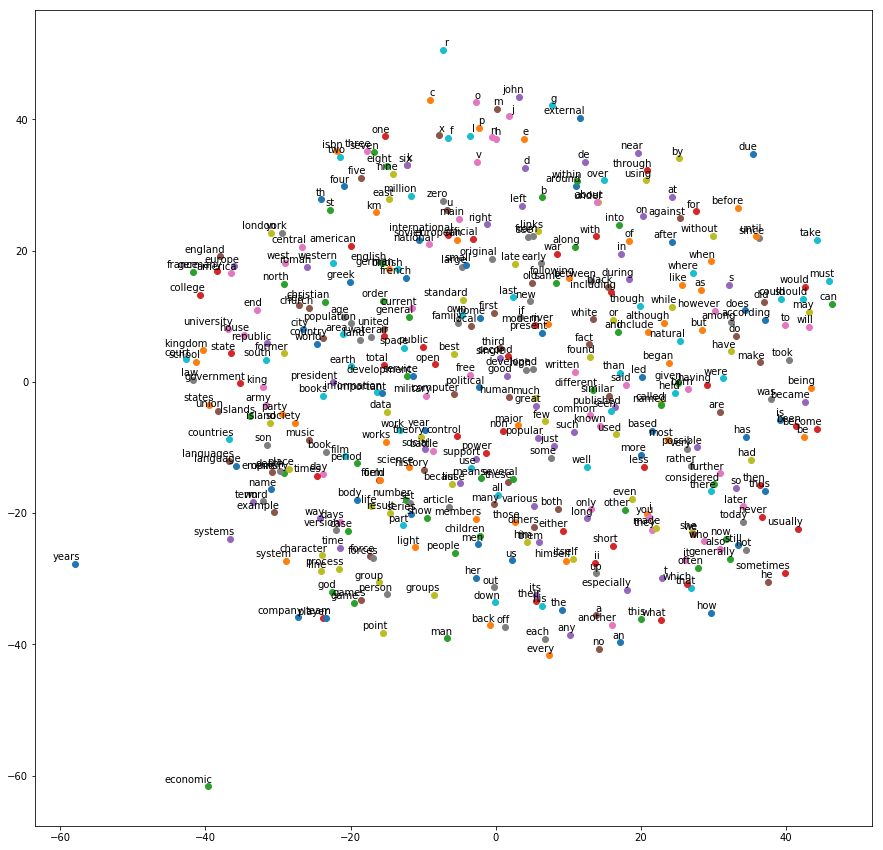

In [10]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [49]:
def generate_batch_cbow(batch_size, skip_window):
    global data_index
    context_window = 2 * skip_window # calculate the context_window - this is the total number of words around the target
    assert batch_size % context_window == 0 # ensure the context window can be taken from the batch size
    num_labels = batch_size / context_window # the number of labels is the how many context windows fit in the batch
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(num_labels, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(num_labels):
        target = skip_window  # target label at the center of the buffer
        labels[i, 0] = buffer[target] # set he label
        targets_to_avoid = [ skip_window ]
        for j in range(context_window):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * context_window + j] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [50]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data. It's just a list of integers! We'll need to turn these
    # into vectors
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # Variables. embeddings turns our integers, representing words,
    # into vectors of length = vocabulary_size
    embeddings = tf.Variable(
      tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    
    softmax_weights = tf.Variable(
      tf.truncated_normal([vocabulary_size, embedding_size],
                           stddev=1.0 / math.sqrt(embedding_size)))
    
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
      tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                                 labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))
  
    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [51]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        
        batch_data, batch_labels = generate_batch_cbow(
          batch_size, skip_window)

        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('\nAverage loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized


ValueError: Cannot feed value of shape (64, 1) for Tensor u'Placeholder_1:0', which has shape '(128, 1)'

In [33]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

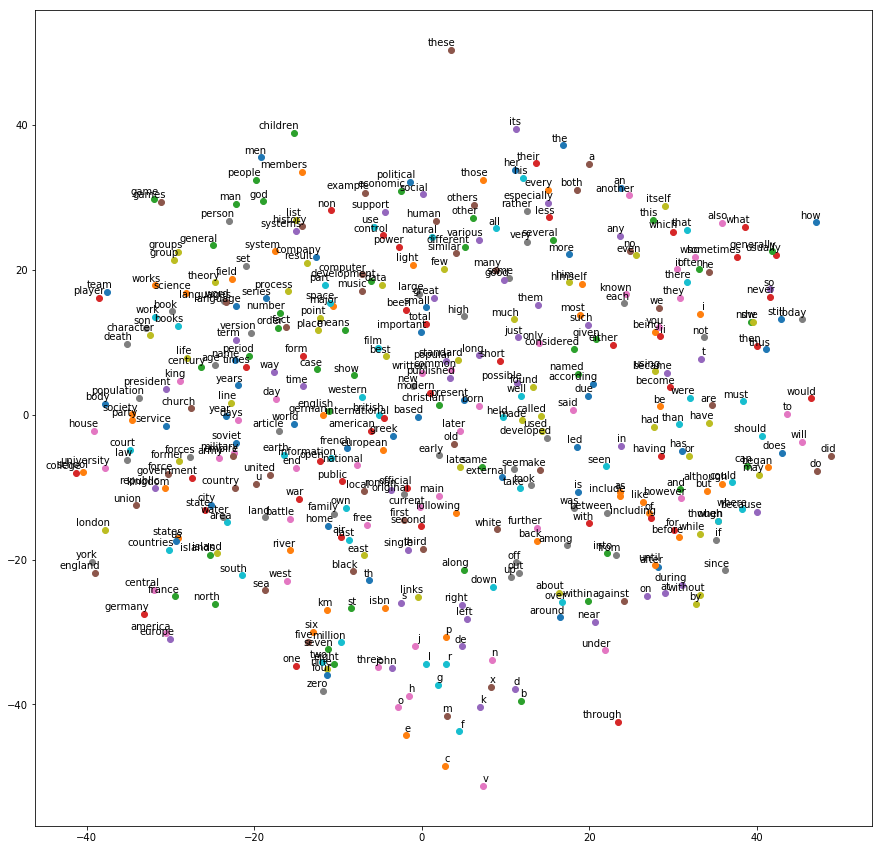

In [34]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)